# Instructions for Manual Simulation

1. Decide on a name for your model.  Add first letter of your name and numbers as prefix  For example: `t0_dummy`.
2. Create a `.py` file with the name of your model in the `trade_models` directory (`./trade_models/t0_dummy.py`)
3. Import your model in `./trade_models/__init__.py` by adding `from . import t0_dummy`
4. Place any pre-trained models or scalers into the `./trade_models/assets/` directory with your model name as prefix.
5. Configure portfolio in the following cells.
    1. For `max_batch_size`, it is purely for memory considerations.  It does an SQL query per batch, so don't make it too small.
6. Run all

In [1]:
start_simulation = '2017-10-01' #YYYY-MM-DD
end_simulation = '2021-12-31' #YYYY-MM-DD
model_name = 't0_dummy'

portfolios = [
    { # start with 1 BTC, trade against ETH
        'portfolio_name' : f'BTC <-> ETH {model_name}',
        'trade_model' : model_name,
        'starting_coin' : 'BTC',
        'pair_coin' : 'ETH',
        'max_batch_size' : 10000,
        'starting_funds' : 1,    
    },
    { # start with 1 ETH, trade against BTC
        'portfolio_name' : f'ETH <-> BTC {model_name}',
        'trade_model' : model_name,
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'starting_funds' : 1,    
    },
]

# STOP

You shouldn't need to modify anything below this cell

# CODE FOR SIMULATION STARTS

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re

# models
import trade_models

In [3]:
# local postgres connection only
import hidden
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [4]:
# validate inputs and portfolio parameters

import datetime
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(start_simulation)
validate(end_simulation)

for p in portfolios:
    # validate symbol
    assert re.match('^[A-Z]{2,}$', p['starting_coin']), f"{p['starting_coin']} is invalid starting coin"
    assert re.match('^[A-Z]{2,}$', p['pair_coin']), f"{p['pair_coin']} is invalid pair coin"

    # validate starting funds
    assert p['starting_funds'] > 0, "Starting funds for must be > 0"

    # validate batch size
    assert (isinstance(p['max_batch_size'], int) and p['max_batch_size'] > 0), f"{p['max_batch_size']} is not a valid batch size"

    # maybe we should validate model names too!
    # TODO: validate model names

In [5]:
def get_pair_data(base_coin, other_coin):
    sql = f"""
    select
        p.*,
        (p.coin2 = '{base_coin}') as reverse
    from pairs p
    where
        (p.coin1 = '{base_coin}' and p.coin2 = '{other_coin}')
            or
        (p.coin2 = '{base_coin}' and p.coin1 = '{other_coin}')
    """
    df = pd.read_sql_query(sql, conn)
    if len(df) == 0:
        return None
    else:
        return df.iloc[0]

In [6]:
def get_batch_data(pair_id, start_time, end_time, batch_size, reverse):
    # TODO: this needs to be expanded to include engineered features
    sql = f"""
    select * from candlestick_15m cm 
    where
        cm.pair_id = {pair_id}
        and cm.close_time notnull
        and cm.open_time between '{start_time}' and '{end_time}'
    order by cm.open_time limit {batch_size}
    """
    df = pd.read_sql_query(sql, conn)

    if reverse:
        # maybe a better way to specify the columns?
        df[['open', 'high', 'low', 'close']] = 1/df[['open', 'high', 'low', 'close']]
    return df

In [7]:
def simulate_portfolio(start_time, end_time, portfolio):
    portfolio_name = portfolio['portfolio_name']
    trade_model = portfolio['trade_model']
    starting_coin = portfolio['starting_coin']
    pair_coin = portfolio['pair_coin']
    max_batch_size = portfolio['max_batch_size']
    starting_funds = portfolio['starting_funds']
    
    pair_data = get_pair_data(starting_coin, pair_coin)

    model = trade_models.__dict__[trade_model]
    columns = model.columns()

    current_time = start_time
    all_output = []
    
    info_dict = {'portfolio':portfolio}

    while True:
        # this batch data should also include feature engineering
        batch_data = get_batch_data(pair_data['id'], current_time, end_time, max_batch_size, pair_data['reverse'])

        if len(batch_data) == 0:
            break

        batch_model_decision = model.make_decision(batch_data[columns], info_dict)

        output = batch_data[['open_time','open', 'high', 'low', 'close']].copy()
        output['trade_decision'] = batch_model_decision

        all_output.append(output)
        current_time = batch_data['close_time'].max()

    results = pd.concat(all_output).set_index('open_time')
    
    results[['fund1','fund2','action']] = np.nan
    cur_funds = [starting_funds,0]
    results.iloc[0, results.columns.get_loc('fund1')] = starting_funds
    results.iloc[0, results.columns.get_loc('fund2')] = 0

    for x,r in results.iterrows():
        if cur_funds[0] > 0:
            if r['trade_decision'] == 1:
                cur_funds[1] = (cur_funds[0] * r['close'])
                cur_funds[0] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'buy'
        else:
            if r['trade_decision'] == -1:
                cur_funds[0] = (cur_funds[1] / r['open'])
                cur_funds[1] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'action'] = 'sell'
    results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
    results['total_value'] = results['fund1'] + results['fund2'] / results['close']
    results['action'] = results['action'].fillna('none')
    return portfolio_name, results

In [8]:
simulation_results = {}

for p in portfolios:
    print(f"Simulating \"{p['portfolio_name']}\"")
    name, res = simulate_portfolio(start_simulation, end_simulation, p)
    simulation_results[name] = res
    print(f"Final value: {res.iloc[-1,-1]}\n\n")

Simulating "BTC <-> ETH t0_dummy"
Final value: 3.177229454032086


Simulating "ETH <-> BTC t0_dummy"
Final value: 0.645537038006884




# END SIMULATION

I have some basic visualization and results below.

In [9]:
for k,v in simulation_results.items():
    print(k)
    print(f"Portfolio simulation for {p['starting_funds']} {p['starting_coin']} trading against {p['pair_coin']}")
    display(v[v['action']!='none'])
    display(v['action'].value_counts())

BTC <-> ETH t0_dummy
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2017-10-01 06:00:00,14.409222,14.260250,14.448153,14.270832,1,0.000000,14.270832,buy,1.000000
2017-10-01 10:00:00,14.360388,14.291431,14.436472,14.436472,-1,0.993764,0.000000,sell,0.993764
2017-10-01 14:00:00,14.447735,14.358120,14.489394,14.359151,1,0.000000,14.269602,buy,0.993764
2017-10-01 16:00:00,14.261673,14.236902,14.313319,14.303082,-1,1.000556,0.000000,sell,1.000556
2017-10-03 12:00:00,14.739480,14.558372,14.781747,14.594066,1,0.000000,14.602180,buy,1.000556
...,...,...,...,...,...,...,...,...,...
2021-07-06 11:45:00,14.887820,14.813498,14.903130,14.855751,-1,3.181038,0.000000,sell,3.181038
2021-07-17 16:15:00,16.782466,16.694491,16.791483,16.694491,1,0.000000,53.105802,buy,3.181038
2021-07-17 18:15:00,16.735281,16.643643,16.736402,16.673892,-1,3.173284,0.000000,sell,3.173284


none    131760
sell       647
buy        647
Name: action, dtype: int64

ETH <-> BTC t0_dummy
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_decision,fund1,fund2,action,total_value
open_time,,,,,,,,,
2017-10-01 10:00:00,0.069636,0.069972,0.069269,0.069269,1,0.000000,0.069269,buy,1.000000
2017-10-01 12:00:00,0.068960,0.069369,0.068891,0.069046,-1,1.004481,0.000000,sell,1.004481
2017-10-02 14:00:00,0.068032,0.068053,0.067472,0.067619,1,0.000000,0.067922,buy,1.004481
2017-10-02 16:00:00,0.067758,0.068088,0.067415,0.067834,-1,1.002420,0.000000,sell,1.002420
2017-10-03 06:00:00,0.068670,0.068805,0.068156,0.068271,1,0.000000,0.068436,buy,1.002420
...,...,...,...,...,...,...,...,...,...
2021-07-08 23:45:00,0.064657,0.064689,0.064342,0.064366,-1,0.653030,0.000000,sell,0.653030
2021-07-13 11:45:00,0.060958,0.060971,0.060429,0.060461,1,0.000000,0.039483,buy,0.653030
2021-07-13 13:45:00,0.060831,0.060900,0.060612,0.060743,-1,0.649058,0.000000,sell,0.649058


none    131778
sell       638
buy        638
Name: action, dtype: int64

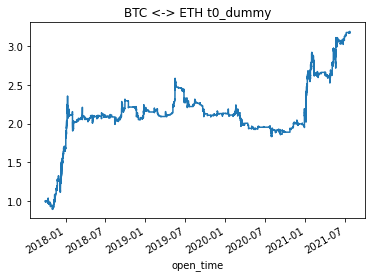

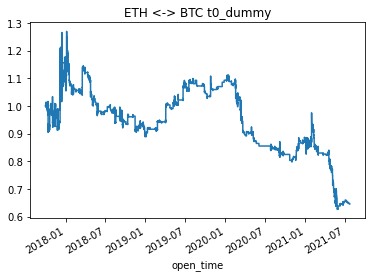

In [10]:
import matplotlib.pyplot as plt
for k,v in simulation_results.items():
    fig, ax = plt.subplots()
    ax.set_title(k)
    v.total_value.plot(figure=fig)

<AxesSubplot:xlabel='open_time'>

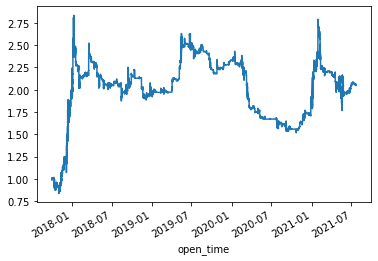

In [11]:
# multiply the 2 together, what if we invested in both at the same time using the same strategies?
(simulation_results[f'BTC <-> ETH {model_name}']['total_value']*simulation_results[f'ETH <-> BTC {model_name}']['total_value']).plot()